#  Resampling
* Model Assessment - evaluating a model's performance
* Model Selection - selecting the proper level of flexibility
    * *flexibility* can be defined in many ways, as we have seen
        * number of features in the regression model
        * generally number of parameters estimated 
        * how much a fitted model can vary with the training data
* Train, Test, Validate
    * We have seen in the class so far the idea of splitting data into Train and Test
        * This allowed us to measure how well our model *generalizes* to non-training data
        * We have learned to evaluate the chosen model's performance on training and test data (and importantly how to *compare* models and their trade-offs)
        * What we have really been doing is *Validating*, because we don't have a true test set
            * We want to use validation to get the best model we can, then it will be tested
        * Can we use model testing in Assessment and Model Selection?

## Cross-Validation (*CV*)
* Select a percentage of the dataset to use for validation, then repeatedly take samples with replacement to create many train/validation pairs.
* *Leave-one-out cross validation* occurs when the number of data points used for validation is $n$, and therefore the number of train/validation pairs is $n$.
    * This is a special case of generalized *CV*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols, logit
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import ShuffleSplit
import scipy.stats as ss
import seaborn as sns
from itertools import product
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import warnings

# Turn off pandas warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)


from ISLP import load_data
Smarket = load_data('Smarket')
Smarket

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


The ``Smarket'' dataset contains a 1250 days of S&P 500 index percentage returns. The data dictionary is as follows:
* Year: year of the return
* Lag1 - Lag5: 1 to 5 days lagged returns
* Volume: the number of shares traded on the previous day (in billions)
* Today: the percentage return on the day in question
* Direction: whether the return was positive or negative on the day in question

Create a training dataset of all days from 2004 and earlier. The test set is data from 2005.

In [2]:
Smarket = pd.get_dummies(Smarket, columns=['Direction'], drop_first=True)
Smarket['Direction_Up'] = Smarket['Direction_Up'].astype(int)
Smarket

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction_Up
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,1
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,1
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,0
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,1
4,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,1
...,...,...,...,...,...,...,...,...,...
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,1
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,0
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,1
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,0


<Axes: xlabel='Day'>

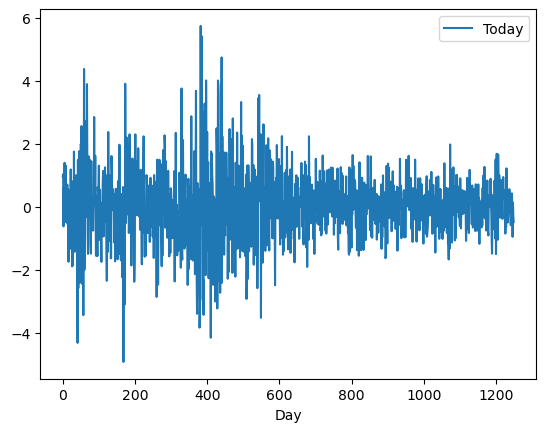

In [3]:
Smarket['Day'] = Smarket.index.copy()
Smarket.plot(x='Day', y='Today')

In [4]:
year_day_max_dict = Smarket.groupby('Year')['Day'].max().to_dict()
Smarket['Year_Day'] = Smarket.apply(lambda x: x['Year'] + x['Day'] / year_day_max_dict[x['Year']], axis=1)
Smarket

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction_Up,Day,Year_Day
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,1,0,2001.000000
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,1,1,2001.004149
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,0,2,2001.008299
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,1,3,2001.012448
4,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,1,4,2001.016598
...,...,...,...,...,...,...,...,...,...,...,...
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,1,1245,2005.996797
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,0,1246,2005.997598
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,1,1247,2005.998399
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,0,1248,2005.999199


<Axes: xlabel='Day'>

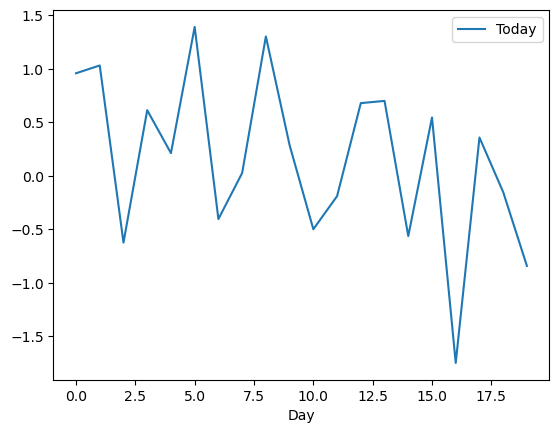

In [5]:
Smarket[0:20].plot(x='Day', y='Today')

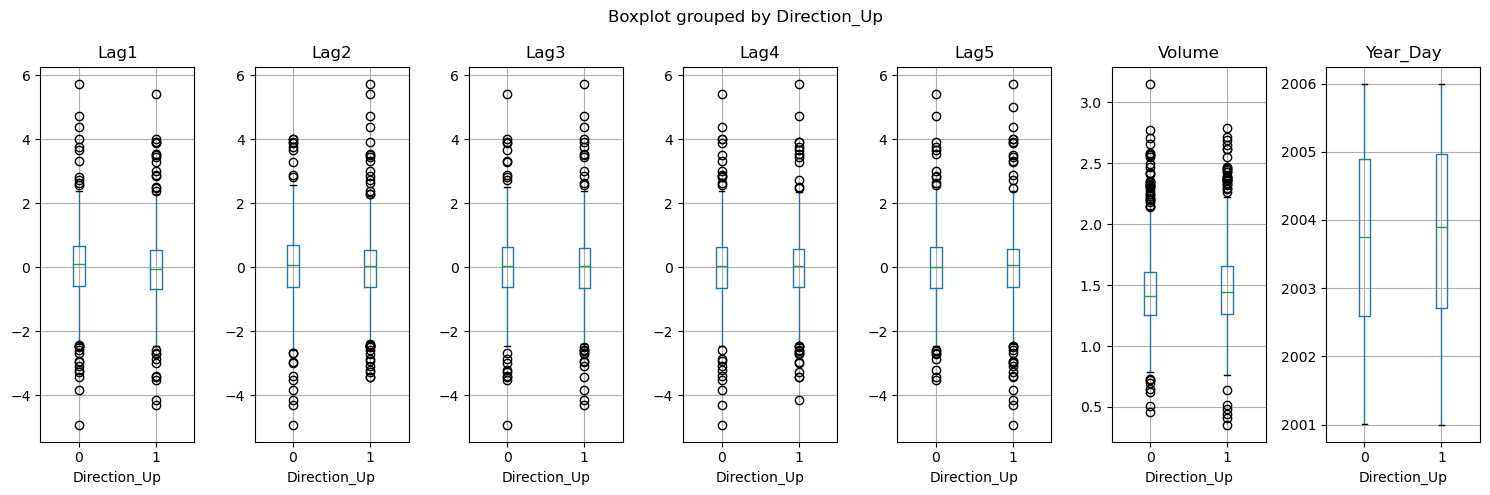

In [6]:
fig, ax = plt.subplots(1, 7, figsize=(15, 5))
for (i, col) in enumerate(['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Year_Day']):
    Smarket.boxplot(column=[col], by='Direction_Up', ax=ax[i])
plt.tight_layout()

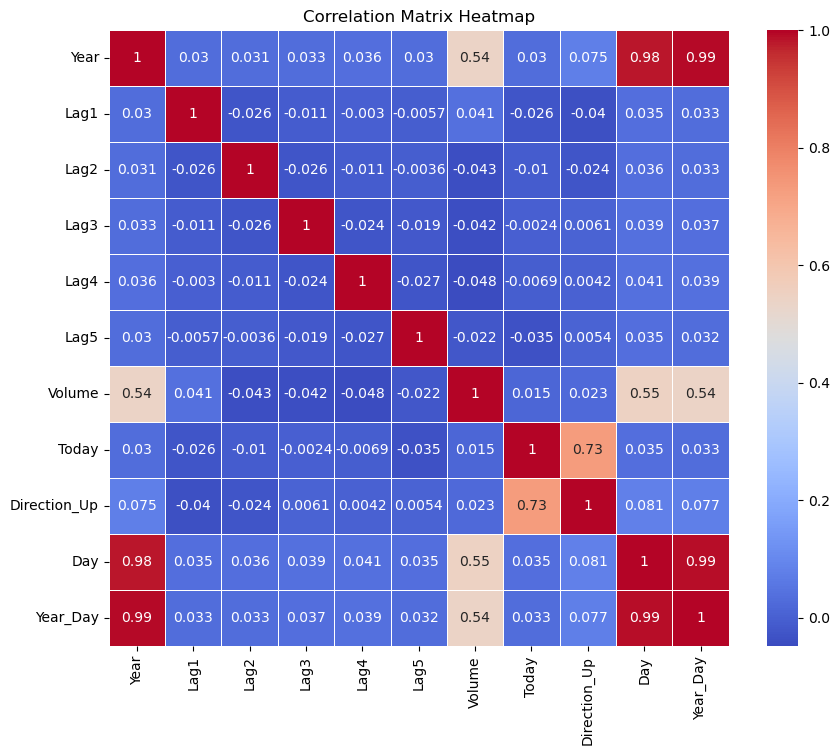

In [7]:
corr_matrix = Smarket.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

## K Fold Cross Validation
* First we'll take out our test set.
* Then we'll use the training set to get many different *folds* or samples of train and validation data
* How many *folds* and what percentage for each validation set?
    * There is a tradeoff here:
        * *Computational Expense*: for each fold, we'll need to fit our model
        * For example with Leave One Out Cross Validation, we have to fit our model $n$ times - THIS WILL MINIMIZE BIAS, THIS ESTIMATE WILL HAVE HIGH VARIANCE, because regardless of the dataset our estimates will be very similar accross all $n$ folds, therefore from dataset to dataset the differences will be great
        * Empirical analysis has shown that 5 to 10 folds perform well accross a wide range of problem settings
* What is this estimate we talk of? 
    * Usually we are talking of some model assessment metric, e.g. MSE, accuracy, AUC
    * Let the metric be $M_i$ for fold $i$, then we have that the cross validation matric with $k$ folds is just the average of the estimate over the folds:
$
\begin{equation}
CV_k = \frac{1}{k} \sum_{i = 1}^k M_i
\end{equation}
$

In [8]:
train = Smarket.loc[Smarket['Year'] <= 2004]
test = Smarket.loc[Smarket['Year'] == 2005]

In [9]:
training_set, validation_set = train_test_split(train, test_size=.2, shuffle=True)
training_set, validation_set

(     Year   Lag1   Lag2   Lag3   Lag4   Lag5  Volume  Today  Direction_Up  \
 104  2001 -0.940  0.546 -1.055  1.299  0.511  0.7262 -0.836             0   
 910  2004  0.012  0.800  0.047 -0.243  0.652  1.0236  0.243             1   
 656  2003 -1.018  0.297 -0.205  0.261  0.916  1.3089  0.065             1   
 506  2003 -1.402 -0.394 -1.443  0.583 -0.141  1.3582 -1.570             0   
 58   2001 -3.439 -1.246  1.078 -0.463 -2.443  1.3861 -0.290             0   
 ..    ...    ...    ...    ...    ...    ...     ...    ...           ...   
 56   2001  1.078 -0.463 -2.443  2.557  1.128  1.2808 -1.246             0   
 892  2004  0.445  0.117  0.457  0.054  0.993  1.2760 -0.626             0   
 947  2004 -0.969  0.525  0.445 -0.930 -0.730  1.7375  0.039             1   
 294  2002 -0.052  1.138 -0.091 -0.986 -0.229  1.1695  0.407             1   
 764  2004 -1.361 -0.980  1.211 -0.209 -0.321  1.8420  0.499             1   
 
      Day     Year_Day  
 104  104  2001.431535  
 910  910  2

In [10]:
def get_metrics(validation_set):
    accuracy = accuracy_score(validation_set[y_var], validation_set['pred'])
        
    fpr = ((validation_set['pred'] == 1) & (validation_set[y_var] == 0)).mean()
    tpr = ((validation_set['pred'] == 1) & (validation_set[y_var] == 1)).mean()
    fnr = ((validation_set['pred'] == 0) & (validation_set[y_var] == 1)).mean()
    tnr = ((validation_set['pred'] == 0) & (validation_set[y_var] == 0)).mean()

    auc_logistic = roc_auc_score(validation_set[y_var], validation_set['score'])

    return accuracy, fpr, tpr, fnr, tnr, auc_logistic

def cross_validate(model_formula, threshold=.5, folds=10):
    llr_pvalues = []
    accuracies = []
    fprs = []
    tprs = []
    fnrs = []
    tnrs = []
    aucs = []

    for i in range(10):
        training_set, validation_set = train_test_split(train, test_size=.2, shuffle=True)
        model = logit(model_formula, data=training_set)
        results = model.fit(disp=False)
        results.summary()

        validation_set['score'] = results.predict(validation_set)
        validation_set['pred'] = (validation_set['score'] > threshold).astype(int)
        
        accuracy, fpr, tpr, fnr, tnr, auc_logistic = get_metrics(validation_set)

        llr_pvalues.append(results.llr_pvalue)
        accuracies.append(accuracy)
        fprs.append(fpr)
        tprs.append(tpr)
        fnrs.append(fnr)
        tnrs.append(tnr)
        aucs.append(auc_logistic)

    print(model_formula)
    print("Average LLR p-value: ", round(np.average(llr_pvalues), 3))
    print("Average Accuracy: ", round(np.average(accuracies), 3))
    print("Average FPR: ", round(np.average(fprs), 3))
    print("Average TPR: ", round(np.average(tprs), 3))
    print("Average FNR: ", round(np.average(fnrs), 3))
    print("Average TNR: ", round(np.average(tnrs), 3))
    print("Average AUC: ", round(np.average(aucs), 3))


y_var = 'Direction_Up'
x_vars_list = ['Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume', 'Lag1 + Lag2 + Lag1*Lag2', 'Lag1 + Year_Day + Year_Day * Lag1']
threshold = .5

for x_vars in x_vars_list:
    model_formula = f"{y_var} ~ {x_vars}"
    cross_validate(model_formula, threshold=threshold)
    print()

Direction_Up ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume
Average LLR p-value:  0.744
Average Accuracy:  0.467
Average FPR:  0.34
Average TPR:  0.309
Average FNR:  0.192
Average TNR:  0.159
Average AUC:  0.464

Direction_Up ~ Lag1 + Lag2 + Lag1*Lag2
Average LLR p-value:  0.608
Average Accuracy:  0.475
Average FPR:  0.334
Average TPR:  0.31
Average FNR:  0.19
Average TNR:  0.164
Average AUC:  0.51

Direction_Up ~ Lag1 + Year_Day + Year_Day * Lag1
Average LLR p-value:  0.137
Average Accuracy:  0.535
Average FPR:  0.256
Average TPR:  0.299
Average FNR:  0.209
Average TNR:  0.236
Average AUC:  0.542



## Testing

In [11]:
for x_vars in x_vars_list:
    model_formula = f"{y_var} ~ {x_vars}"
    model = logit(model_formula, data=train)
    results = model.fit(disp=False)
    results.summary()

    test['score'] = results.predict(test)
    test['pred'] = (test['score'] > threshold).astype(int)

    accuracy, fpr, tpr, fnr, tnr, auc_logistic = get_metrics(test)
    print(model_formula)
    print("Average Accuracy: ", round(accuracy, 3))
    print("Average FPR: ", round(fpr, 3))
    print("Average TPR: ", round(tpr, 3))
    print("Average FNR: ", round(fnr, 3))
    print("Average TNR: ", round(tnr, 3))
    print("Average AUC: ", round(auc_logistic, 3))
    print()

Direction_Up ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume
Average Accuracy:  0.48
Average FPR:  0.135
Average TPR:  0.175
Average FNR:  0.385
Average TNR:  0.306
Average AUC:  0.52

Direction_Up ~ Lag1 + Lag2 + Lag1*Lag2
Average Accuracy:  0.56
Average FPR:  0.302
Average TPR:  0.421
Average FNR:  0.139
Average TNR:  0.139
Average AUC:  0.559

Direction_Up ~ Lag1 + Year_Day + Year_Day * Lag1
Average Accuracy:  0.563
Average FPR:  0.437
Average TPR:  0.56
Average FNR:  0.0
Average TNR:  0.004
Average AUC:  0.554



In [12]:
model_formula = "Direction_Up ~ Lag1 + Year_Day + Year_Day * Lag1"
model = logit(model_formula, data=train)
results = model.fit(disp=False)
test['score'] = results.predict(test)
test['pred'] = (test['score'] > threshold).astype(int)
test['Direction_Up'].mean(), test['pred'].mean()

(0.5595238095238095, 0.996031746031746)

In [13]:
model_formula = "Direction_Up ~ Lag1 + Lag2 + Lag1*Lag2"
model = logit(model_formula, data=train)
results = model.fit(disp=False)
test['score'] = results.predict(test)
test['pred'] = (test['score'] > threshold).astype(int)

money = 100

def get_return(money, sample):
    for i in sample.index:
        if sample.loc[i]['pred'] == 1:
            money *= (1 + sample.loc[i]['Today'] / 100)
    return money


print("Return: ", get_return(money, test))

Return:  107.70639260599118


## Bootstrapping
* When we learn about the result above, it is too late to change anything. Can we get an estimate of our performance before testing?
* In bootstrapping, we sample from the data available to generate estimates of metrics of importance. Just as before, we can calculate statistics on the bootstrap samples...

Average return:  100.04910985700495
	Standard deviation:  2.8479647904030956


(array([  2.,   5.,   6.,  15.,  35., 165., 333., 366.,  62.,  11.]),
 array([ 83.71873885,  86.16152896,  88.60431907,  91.04710918,
         93.48989929,  95.93268941,  98.37547952, 100.81826963,
        103.26105974, 105.70384985, 108.14663996]),
 <BarContainer object of 10 artists>)

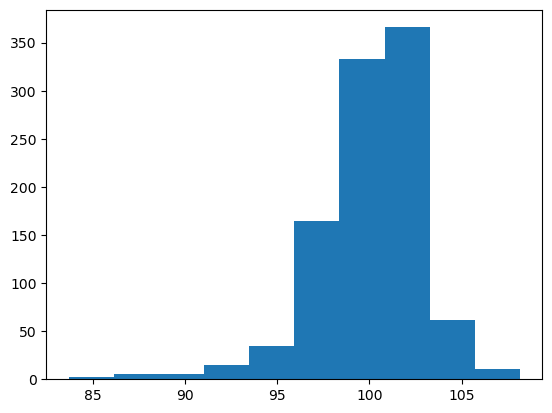

In [17]:
def bootstrap_return(money, investment_period, model_formula, sample_type="time"):
    
    model = logit(model_formula, data=train)
    results = model.fit(disp=False)
    train['score'] = results.predict(train)
    train['pred'] = (train['score'] > threshold).astype(int)
    returns = []

    for i in range(1000):
        if sample_type == "time":
            sample_start = np.random.randint(train.index.min(), train.index.max() - investment_period)
            sample = train.loc[sample_start: sample_start + investment_period]
        else:
            sample = train.sample(investment_period)
        returns.append(get_return(money, sample))
    return returns

model_formula = "Direction_Up ~ Lag1 + Lag2 + Lag1*Lag2"
threshold = .5
money = 100
investment_period = 10

returns = bootstrap_return(money, investment_period, model_formula,sample_type='time')
print("Average return: ", np.average(returns))
print("\tStandard deviation: ", np.sqrt(np.var(returns)))

plt.hist(returns)